In [45]:
#import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing GBM-TP dataset
df= pd.read_csv("GBM features.csv")# header=None, skiprows=1)
#df = df.rename(columns=df.iloc[0]).drop(df.index[0])

#dropping last 7 rows
df = df[:-7]

col_list = list()
for col in df.columns:
    col_list.append(col)

CLIs_col_list = col_list[0:13]
CLIs_col_list

CLIs_df = df.filter(CLIs_col_list, axis=1)

#Processed features:
key = ['tcga_participant_barcode']

numerical_CLIs_list = [
    'CLI_years_to_birth', #age
    'CLI_days_to_death',  #changed to Overall_Survival
    'CLI_date_of_initial_pathologic_diagnosis', #seemes useless, unless we want to generalise that "technological advancement prolongs life"?
    'CLI_karnofsky_performance_score' #range from 0 to 100. A higher score means the patient is better able to carry out daily activities.
]

categorical_CLIs_list = [
    'CLI_gender',
    'CLI_radiation_therapy',    #better convert yes/no to 0/1
    'CLI_histological_type',    #3 forms, ['untreated primary (de novo) gbm' 'treated primary gbm', 'glioblastoma multiforme (gbm)']
    'CLI_race',             #4 forms, ['white' 'black or african american' nan 'asian']. 
    'CLI_ethnicity'         #3 forms, [nan 'hispanic or latino' 'not hispanic or latino'].
]

#Modify df according to processed features:
processed_CLIs_df = CLIs_df.filter(key + numerical_CLIs_list + categorical_CLIs_list, axis=1)
processed_CLIs_df = processed_CLIs_df[processed_CLIs_df['CLI_days_to_death'].notnull()]
processed_CLIs_df.rename(columns={'CLI_days_to_death': 'Overall_Survival'}, inplace=True)
processed_CLIs_df

#one-hot encoding
#for columns which null values exist(all columns except gender), drop_first=false since the categories are not collectively exhausive
# -->0 in all categories implies NaN

genderDummy = pd.get_dummies(processed_CLIs_df['CLI_gender'],drop_first=True,prefix='CLI_gender')
radiationDummy = pd.get_dummies(processed_CLIs_df['CLI_radiation_therapy'],drop_first=False,prefix='CLI_radiation_therapy')
histologicalDummy = pd.get_dummies(processed_CLIs_df['CLI_histological_type'],drop_first=False,prefix='CLI_histological_type')
raceDummy = pd.get_dummies(processed_CLIs_df['CLI_race'],drop_first=False,prefix='CLI_race')
ethnicityDummy = pd.get_dummies(processed_CLIs_df['CLI_ethnicity'],drop_first=False,prefix='CLI_ethnicity')

processed_CLIs_df = processed_CLIs_df.drop(columns=['CLI_gender','CLI_radiation_therapy','CLI_histological_type','CLI_race','CLI_ethnicity'])
processed_CLIs_df = pd.concat([processed_CLIs_df,genderDummy,radiationDummy,histologicalDummy,raceDummy,ethnicityDummy],axis=1,sort=True)

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].median()

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].fillna(processed_CLIs_df['CLI_karnofsky_performance_score'].median(), inplace=True)

# define the datafram for feature and target
X = processed_CLIs_df.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1)
y = processed_CLIs_df[['Overall_Survival']]



Combining genomic(SVD)


In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
genomic_df_0.drop(['tcga_participant_barcode'], axis=1, inplace = True)

#SVD
# Perform SVD matrix factorization to extract features
U, s, V = np.linalg.svd(genomic_df_0.to_numpy(), full_matrices=False)
pd.DataFrame(U[:, :50]) # Select the top 50 features out of 595 cols in U



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.000117,0.000651,0.000917,0.000605,-0.002080,0.029418,-0.004312,0.001773,-0.008499,0.001452,...,0.016575,-0.013533,0.016591,-0.006121,0.013769,-0.019911,0.008043,-0.030574,0.016663,-0.016007
1,-0.011279,0.080161,0.028964,0.022265,-0.000316,0.004716,0.017431,-0.038336,0.013752,0.040128,...,0.023411,0.001994,0.071899,0.028153,0.026566,-0.003987,0.020099,0.009168,0.076148,0.009189
2,-0.000077,0.000458,0.000234,0.000483,-0.000460,0.017371,-0.003057,0.000345,-0.003957,0.002566,...,-0.003014,-0.001062,-0.008585,-0.011622,-0.008820,0.006360,-0.002060,0.005832,-0.005279,0.006126
3,-0.000113,0.000685,0.000639,0.000806,-0.002515,0.027093,-0.004193,0.001727,-0.005622,0.004340,...,0.004763,-0.013020,-0.003563,0.034968,0.025647,0.019994,0.014249,0.018912,0.023333,0.017326
4,-0.000218,0.001249,0.001511,0.001492,-0.004460,0.055221,-0.009462,0.004348,-0.013152,-0.000514,...,0.009676,-0.012418,-0.000911,-0.009745,0.016754,0.018848,-0.031570,-0.009484,0.048998,-0.014198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,-0.011515,0.082286,0.007737,0.008163,-0.038595,0.011094,0.001348,-0.000068,0.003999,-0.011047,...,-0.017285,-0.004112,0.028501,-0.002309,-0.002727,-0.005183,-0.007325,0.016657,0.002386,0.005243
591,-0.000142,0.000879,0.001733,0.000691,-0.002792,0.031529,-0.003034,0.001699,-0.003018,-0.001462,...,0.014991,-0.006724,0.007680,-0.011276,0.006180,0.001012,-0.002396,0.018135,-0.014612,0.005637
592,-0.000087,0.000545,0.000991,0.000744,-0.002232,0.019648,-0.003206,0.000457,-0.000332,0.002612,...,-0.001180,0.011437,-0.004426,0.016403,0.009157,0.017768,0.016132,0.002826,0.009299,0.018534
593,-0.000094,0.000600,0.000689,0.000697,-0.002088,0.020055,-0.003811,0.000368,-0.000472,0.003282,...,-0.000915,0.006502,-0.014937,-0.003251,0.025340,0.030716,-0.008431,-0.010500,0.071337,0.009126


In [47]:
SVD_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, U[:, :50])))
SVD_genomic_X = SVD_genomic_X.rename(columns={0: 'tcga_participant_barcode'})
SVD_genomic_X

,tcga_participant_barcode,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,TCGA-02-0001,-0.000117,0.000651,0.000917,0.000605,-0.00208,0.029418,-0.004312,0.001773,-0.008499,...,0.016575,-0.013533,0.016591,-0.006121,0.013769,-0.019911,0.008043,-0.030574,0.016663,-0.016007
1,TCGA-02-0003,-0.011279,0.080161,0.028964,0.022265,-0.000316,0.004716,0.017431,-0.038336,0.013752,...,0.023411,0.001994,0.071899,0.028153,0.026566,-0.003987,0.020099,0.009168,0.076148,0.009189
2,TCGA-02-0004,-0.000077,0.000458,0.000234,0.000483,-0.00046,0.017371,-0.003057,0.000345,-0.003957,...,-0.003014,-0.001062,-0.008585,-0.011622,-0.00882,0.00636,-0.00206,0.005832,-0.005279,0.006126
3,TCGA-02-0006,-0.000113,0.000685,0.000639,0.000806,-0.002515,0.027093,-0.004193,0.001727,-0.005622,...,0.004763,-0.01302,-0.003563,0.034968,0.025647,0.019994,0.014249,0.018912,0.023333,0.017326
4,TCGA-02-0007,-0.000218,0.001249,0.001511,0.001492,-0.00446,0.055221,-0.009462,0.004348,-0.013152,...,0.009676,-0.012418,-0.000911,-0.009745,0.016754,0.018848,-0.03157,-0.009484,0.048998,-0.014198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,TCGA-87-5896,-0.011515,0.082286,0.007737,0.008163,-0.038595,0.011094,0.001348,-0.000068,0.003999,...,-0.017285,-0.004112,0.028501,-0.002309,-0.002727,-0.005183,-0.007325,0.016657,0.002386,0.005243
591,TCGA-OX-A56R,-0.000142,0.000879,0.001733,0.000691,-0.002792,0.031529,-0.003034,0.001699,-0.003018,...,0.014991,-0.006724,0.00768,-0.011276,0.00618,0.001012,-0.002396,0.018135,-0.014612,0.005637
592,TCGA-RR-A6KA,-0.000087,0.000545,0.000991,0.000744,-0.002232,0.019648,-0.003206,0.000457,-0.000332,...,-0.00118,0.011437,-0.004426,0.016403,0.009157,0.017768,0.016132,0.002826,0.009299,0.018534
593,TCGA-RR-A6KB,-0.000094,0.0006,0.000689,0.000697,-0.002088,0.020055,-0.003811,0.000368,-0.000472,...,-0.000915,0.006502,-0.014937,-0.003251,0.02534,0.030716,-0.008431,-0.0105,0.071337,0.009126


In [48]:
#merge CLI and Genomic
SVD_full_X = pd.merge(processed_CLIs_df, SVD_genomic_X, on='tcga_participant_barcode', how='inner')
SVD_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
#normalization
zscore_scaler = preprocessing.StandardScaler().fit(SVD_full_X)
SVD_full_X = pd.DataFrame(zscore_scaler.transform(SVD_full_X), columns = SVD_full_X.columns)
SVD_full_X_train, SVD_full_X_test, y_train, y_test = train_test_split(SVD_full_X, y, test_size=0.2,random_state =42)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
import keras as K
import tensorflow as tf
from keras.layers import Dense, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#NN
sc = StandardScaler()
SVD_full_X_train = sc.fit_transform(SVD_full_X_train)
SVD_full_X_test = sc.transform(SVD_full_X_test)

def build_full_NN(num_input_layer_unit, num_first_layer_unit=17, num_second_layer_unit=8):
    # Initialising the ANN
    full_NN_model = Sequential()

    # Adding the input layer and the first hidden layer
    full_NN_model.add(Dense(num_first_layer_unit, activation = 'relu', input_dim = num_input_layer_unit))

    # Adding the second hidden layer
    full_NN_model.add(Dense(units = num_second_layer_unit, activation = 'relu'))
    """
    # Adding the third hidden layer
    full_NN_model.add(Dense(units = 4, activation = 'relu'))
    """

    # Adding the output layer
    full_NN_model.add(Dense(units = 1))

    # Compiling the ANN
    full_NN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    return full_NN_model

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

In [53]:
SVD_full_X.describe()

,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,...,41,42,43,44,45,46,47,48,49,50
count,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,...,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02
mean,-5.404407e-16,-1.746358e-14,-5.991806e-16,-1.404772e-16,-2.379049e-17,-7.625420e-16,1.087565e-16,6.476679e-16,7.794219e-17,4.842498e-16,...,-5.324539e-17,-1.087565e-17,2.489505e-17,2.209117e-17,-9.969350e-18,-9.176333e-18,3.428380e-17,-1.551338e-17,-1.770126e-18,-7.930164e-19
std,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,...,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00
min,-3.448415e+00,-2.954339e+00,-5.851225e+00,-1.289590e+00,-4.184017e-01,-2.025874e+00,-2.168145e-01,-2.008475e-01,-3.309263e+00,-1.203859e-01,...,-3.519287e+00,-3.935259e+00,-9.119664e+00,-4.579304e+00,-4.733801e+00,-5.226012e+00,-4.306881e+00,-4.202880e+00,-4.029801e+00,-4.992242e+00
25%,-5.260047e-01,-5.782600e-01,1.657745e-01,-1.289590e+00,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,-3.727077e-01,-4.279548e-01,-2.530344e-01,-3.181532e-01,-3.792977e-01,-3.912963e-01,-3.045517e-01,-3.682996e-01,-3.566997e-01,-3.232522e-01
50%,4.422163e-02,2.137663e-01,1.657745e-01,7.754400e-01,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,-2.345464e-02,-8.818203e-03,7.104131e-02,-2.845514e-02,-3.246502e-02,-6.278007e-03,-4.386891e-02,4.532424e-02,-7.238473e-02,5.230643e-02
75%,6.857263e-01,8.077860e-01,1.657745e-01,7.754400e-01,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,3.438398e-01,3.984234e-01,3.881142e-01,3.569849e-01,2.982261e-01,4.073810e-01,2.595064e-01,3.600823e-01,4.303300e-01,3.487394e-01
max,2.182570e+00,1.797819e+00,1.670024e+00,7.754400e-01,2.390048e+00,4.936140e-01,4.612237e+00,4.978903e+00,3.021821e-01,8.306624e+00,...,5.743783e+00,5.855512e+00,4.370257e+00,6.313704e+00,7.371368e+00,4.244022e+00,5.084952e+00,5.207944e+00,3.525146e+00,3.811863e+00


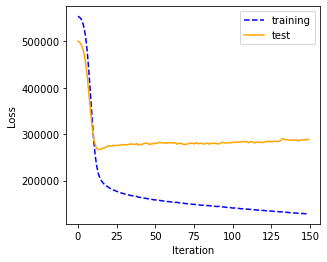

(train rmse, test rmse)=(356.39,537.3)


In [56]:
''' Plot loss-iteration for (350, 30, 20) '''
SVD_full_NN_model = build_full_NN(64, 30, 20)
SVD_full_history = SVD_full_NN_model.fit(SVD_full_X_train, y_train, validation_data=(SVD_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_NN_model.predict(SVD_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_NN_model.predict(SVD_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

In [58]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    SVD_full_NN_model = build_full_NN(64, a, b)
    SVD_full_history = SVD_full_NN_model.fit(SVD_full_X_train, y_train, validation_data=(SVD_full_X_test, y_test), batch_size = 10, epochs = 50, verbose = 0)
    train_rms = mean_squared_error(y_train, SVD_full_NN_model.predict(SVD_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, SVD_full_NN_model.predict(SVD_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,446.05,532.54)
(first_layer, second_layer, train rmse, test rmse)=(8,6,422.04,538.5)
(first_layer, second_layer, train rmse, test rmse)=(8,8,426.64,542.63)
(first_layer, second_layer, train rmse, test rmse)=(8,10,428.31,542.51)
(first_layer, second_layer, train rmse, test rmse)=(8,12,428.57,542.36)
(first_layer, second_layer, train rmse, test rmse)=(8,14,418.07,551.17)
(first_layer, second_layer, train rmse, test rmse)=(8,16,418.97,553.25)
(first_layer, second_layer, train rmse, test rmse)=(8,18,415.18,540.84)
(first_layer, second_layer, train rmse, test rmse)=(8,20,416.27,533.84)
(first_layer, second_layer, train rmse, test rmse)=(8,22,408.12,537.61)
(first_layer, second_layer, train rmse, test rmse)=(8,24,419.05,555.55)
(first_layer, second_layer, train rmse, test rmse)=(10,4,432.95,545.48)
(first_layer, second_layer, train rmse, test rmse)=(10,6,423.08,531.44)
(first_layer, second_layer, train rmse, test rmse)=(10,8,417.73,534.

In [59]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(26, 18, 404.86674625919716, 526.560382630491)

much worse(+80) than lasso-selected NN

now try again but only use lasso selected

In [100]:
lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]

#SVD
# Perform SVD matrix factorization to extract features
U, s, V = np.linalg.svd(lasso_genomic_df_0.to_numpy(), full_matrices=False)
pd.DataFrame(U) # Select the top 3 features out of 595 cols in U


SVD_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, U[:, :3])))
SVD_lasso_genomic_X = SVD_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
SVD_lasso_full_X = pd.merge(processed_CLIs_df, SVD_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
SVD_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
SVD_lasso_full_X



,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,CLI_race_black or african american,CLI_race_white,CLI_ethnicity_hispanic or latino,CLI_ethnicity_not hispanic or latino,1,2,3
0,44.0,2002.0,80.0,0,0,1,0,0,1,0,0,1,0,1,0.000016,-0.039306,0.047704
1,50.0,2003.0,100.0,1,0,1,0,0,1,0,0,1,0,1,0.053342,-0.005596,0.009
2,59.0,2002.0,80.0,1,0,1,0,0,1,0,0,1,0,1,-0.0,0.0,-0.0
3,56.0,2002.0,80.0,0,0,1,0,0,1,0,0,1,0,1,0.035137,-0.011198,0.007489
4,40.0,2002.0,80.0,0,0,1,0,1,0,0,0,1,0,1,0.002035,-0.001032,-0.008546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,44.0,2011.0,80.0,0,0,1,0,0,1,0,0,1,0,0,0.033021,-0.003121,0.004509
486,64.0,2009.0,40.0,1,1,0,0,0,1,0,0,1,0,0,0.054907,-0.005486,0.014762
487,68.0,2012.0,80.0,1,0,0,1,0,0,0,1,0,0,1,0.057237,-0.020983,-0.090552
488,72.0,2012.0,80.0,0,1,0,1,0,0,0,1,0,0,1,0.03763,-0.003884,-0.000259


In [101]:
#normalization
zscore_scaler = preprocessing.StandardScaler().fit(SVD_lasso_full_X)
SVD_lasso_full_X = pd.DataFrame(zscore_scaler.transform(SVD_lasso_full_X), columns = SVD_lasso_full_X.columns)
SVD_lasso_full_X




c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,CLI_race_black or african american,CLI_race_white,CLI_ethnicity_hispanic or latino,CLI_ethnicity_not hispanic or latino,1,2,3
0,-1.024953,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-1.548412,-1.035873,1.144515
1,-0.597283,-0.182247,1.670024,0.77544,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,0.845347,-0.166844,0.219410
2,0.044222,-0.380253,0.165774,0.77544,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-1.549115,-0.022581,0.004304
3,-0.169613,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,0.028141,-0.311263,0.183297
4,-1.310066,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,4.978903,-3.309263,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-1.457764,-0.049185,-0.199955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-1.024953,1.401806,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,-2.230607,-0.066840,-0.103037,0.112085
486,0.400613,1.005793,-2.842725,0.77544,2.390048,-2.025874,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,-2.230607,0.915602,-0.163995,0.357136
487,0.685726,1.599812,0.165774,0.77544,-0.418402,-2.025874,4.612237,-0.200847,-3.309263,-0.120386,3.721355,-2.677063,-0.144338,0.448308,1.020190,-0.563503,-2.160037
488,0.970839,1.599812,0.165774,-1.28959,2.390048,-2.025874,4.612237,-0.200847,-3.309263,-0.120386,3.721355,-2.677063,-0.144338,0.448308,0.140070,-0.122716,-0.001883


In [102]:
y = processed_CLIs_df[['Overall_Survival']]
SVD_lasso_full_X_train, SVD_lasso_full_X_test, y_train, y_test = train_test_split(SVD_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
SVD_lasso_full_X_train = sc.fit_transform(SVD_lasso_full_X_train)
SVD_lasso_full_X_test = sc.transform(SVD_lasso_full_X_test)
SVD_lasso_full_X_train










c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[ 0.47175025, -0.17383308, -2.73306647, ...,  0.37324636,
        -0.03085972,  0.06479468],
       [-0.01563028,  0.63258784,  0.91847428, ..., -0.13953002,
         0.37691107,  0.48170706],
       [ 0.47175025,  0.83419307, -1.27245017, ...,  0.79607266,
         1.34675517, -0.03611593],
       ...,
       [ 0.54137604,  0.43098261, -1.27245017, ...,  0.42440512,
        -0.11961839,  0.26119711],
       [ 0.75025341,  0.83419307,  0.18816613, ...,  0.21461173,
        -0.13477595,  0.08660826],
       [ 0.26287288, -0.77864877,  0.18816613, ..., -1.05756101,
         0.03022644,  0.05117877]])

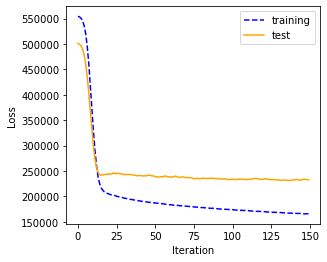

(train rmse, test rmse)=(405.74,482.01)


In [91]:
''' Plot loss-iteration for (30, 20) '''
SVD_full_lasso_NN_model = build_full_NN(17,30, 20)
SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

In [92]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    SVD_full_lasso_NN_model = build_full_NN(17, a, b)
    SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,439.77,499.54)
(first_layer, second_layer, train rmse, test rmse)=(8,6,440.52,498.13)
(first_layer, second_layer, train rmse, test rmse)=(8,8,437.58,499.82)
(first_layer, second_layer, train rmse, test rmse)=(8,10,438.68,496.28)
(first_layer, second_layer, train rmse, test rmse)=(8,12,437.81,497.7)
(first_layer, second_layer, train rmse, test rmse)=(8,14,430.51,498.1)
(first_layer, second_layer, train rmse, test rmse)=(8,16,423.3,495.14)
(first_layer, second_layer, train rmse, test rmse)=(8,18,431.86,479.1)
(first_layer, second_layer, train rmse, test rmse)=(8,20,419.72,460.76)
(first_layer, second_layer, train rmse, test rmse)=(8,22,427.72,487.08)
(first_layer, second_layer, train rmse, test rmse)=(8,24,436.94,499.37)
(first_layer, second_layer, train rmse, test rmse)=(10,4,448.45,523.83)
(first_layer, second_layer, train rmse, test rmse)=(10,6,434.99,497.68)
(first_layer, second_layer, train rmse, test rmse)=(10,8,442.11,517.58)

In [93]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(8, 20, 419.724642160167, 460.7601075387045)

Text(0, 0.5, 'second_layer_nodes')

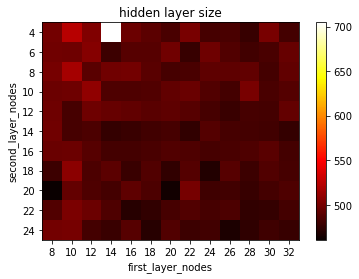

In [94]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")


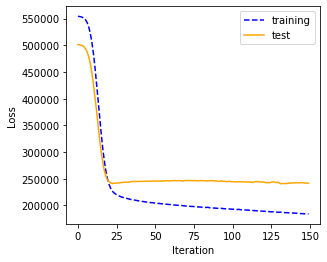

(train rmse, test rmse)=(428.53,491.46)


In [108]:
''' Plot loss-iteration for (26, 24) '''
SVD_full_lasso_NN_model = build_full_NN(17,8, 20)
SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

repeat on using top 5/4 columns

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

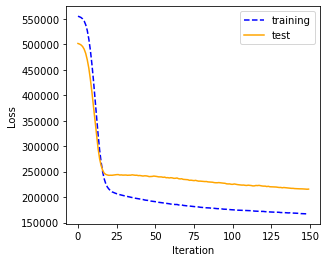

(train rmse, test rmse)=(408.05,464.49)


In [111]:
#5 cols

lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]

#SVD
# Perform SVD matrix factorization to extract features
U, s, V = np.linalg.svd(lasso_genomic_df_0.to_numpy(), full_matrices=False)
pd.DataFrame(U) # Select the top 5 features out of 595 cols in U


SVD_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, U[:, :5])))
SVD_lasso_genomic_X = SVD_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
SVD_lasso_full_X = pd.merge(processed_CLIs_df, SVD_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
SVD_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(SVD_lasso_full_X)
SVD_lasso_full_X = pd.DataFrame(zscore_scaler.transform(SVD_lasso_full_X), columns = SVD_lasso_full_X.columns)

y = processed_CLIs_df[['Overall_Survival']]
SVD_lasso_full_X_train, SVD_lasso_full_X_test, y_train, y_test = train_test_split(SVD_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
SVD_lasso_full_X_train = sc.fit_transform(SVD_lasso_full_X_train)
SVD_lasso_full_X_test = sc.transform(SVD_lasso_full_X_test)

''' Plot loss-iteration for (14, 24) '''
SVD_full_lasso_NN_model = build_full_NN(19,14, 24)
SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


In [112]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    SVD_full_lasso_NN_model = build_full_NN(19, a, b)
    SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,438.71,513.26)
(first_layer, second_layer, train rmse, test rmse)=(8,6,440.53,507.4)
(first_layer, second_layer, train rmse, test rmse)=(8,8,424.5,487.5)
(first_layer, second_layer, train rmse, test rmse)=(8,10,417.13,477.39)
(first_layer, second_layer, train rmse, test rmse)=(8,12,420.07,478.3)
(first_layer, second_layer, train rmse, test rmse)=(8,14,417.13,472.04)
(first_layer, second_layer, train rmse, test rmse)=(8,16,424.45,482.64)
(first_layer, second_layer, train rmse, test rmse)=(8,18,426.3,485.86)
(first_layer, second_layer, train rmse, test rmse)=(8,20,421.98,473.72)
(first_layer, second_layer, train rmse, test rmse)=(8,22,413.77,475.72)
(first_layer, second_layer, train rmse, test rmse)=(8,24,403.3,478.61)
(first_layer, second_layer, train rmse, test rmse)=(10,4,419.26,490.09)
(first_layer, second_layer, train rmse, test rmse)=(10,6,416.72,477.4)
(first_layer, second_layer, train rmse, test rmse)=(10,8,422.88,486.79)
(f

In [113]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(16, 24, 395.7086762510138, 454.0622159178097)

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

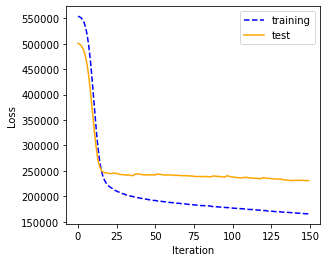

(train rmse, test rmse)=(405.98,480.44)


In [114]:
#4 cols

lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]

#SVD
# Perform SVD matrix factorization to extract features
U, s, V = np.linalg.svd(lasso_genomic_df_0.to_numpy(), full_matrices=False)
pd.DataFrame(U) # Select the top 4 features out of 595 cols in U


SVD_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, U[:, :4])))
SVD_lasso_genomic_X = SVD_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
SVD_lasso_full_X = pd.merge(processed_CLIs_df, SVD_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
SVD_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(SVD_lasso_full_X)
SVD_lasso_full_X = pd.DataFrame(zscore_scaler.transform(SVD_lasso_full_X), columns = SVD_lasso_full_X.columns)

y = processed_CLIs_df[['Overall_Survival']]
SVD_lasso_full_X_train, SVD_lasso_full_X_test, y_train, y_test = train_test_split(SVD_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
SVD_lasso_full_X_train = sc.fit_transform(SVD_lasso_full_X_train)
SVD_lasso_full_X_test = sc.transform(SVD_lasso_full_X_test)

''' Plot loss-iteration for (14, 24) '''
SVD_full_lasso_NN_model = build_full_NN(18,14, 24)
SVD_full_lasso_history = SVD_full_lasso_NN_model.fit(SVD_lasso_full_X_train, y_train, validation_data=(SVD_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_lasso_NN_model.predict(SVD_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


Lastly, try SVD on both CLIs and genomic, instead on transforming genomic only

In [120]:
#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
genomic_df_0

,tcga_participant_barcode,CLUS_mRNA_cNMF,CLUS_mRNA_cHierarchical,CLUS_miR_cNMF,CLUS_miR_cHierarchical,CLUS_CN_cNMF,CLUS_Methlyation_cNMF,CLUS_RPPA_cNMF,CLUS_RPPA_cHierarchical,CLUS_mRNAseq_cNMF,...,Del_SMYD3_1q44_mRNA,Del_TCL1A_14q24.2_mRNA,Del_TCL6_14q24.2_mRNA,Del_TFRC_3q29_mRNA,Del_TNFAIP3_6q22.1_mRNA,Del_TP53_17p13.1_mRNA,Del_TRIP11_14q24.2_mRNA,Del_TSHR_14q24.2_mRNA,Del_WIF1_12q15_mRNA,Del_WWOX_16q23.1_mRNA
0,TCGA-02-0001,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TCGA-02-0003,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCGA-02-0004,1.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCGA-02-0006,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-02-0007,2.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,TCGA-87-5896,3.0,3.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
591,TCGA-OX-A56R,0.0,0.0,0.0,0.0,2.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
592,TCGA-RR-A6KA,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,TCGA-RR-A6KB,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
# on full_X
#5 cols

#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
print("Missing values:")
print(genomic_df_0.isna().sum())


Missing values:
tcga_participant_barcode                                 0
CLI_years_to_birth                                       0
Overall_Survival                                         0
CLI_date_of_initial_pathologic_diagnosis                 0
CLI_karnofsky_performance_score                          0
CLI_gender_male                                          0
CLI_radiation_therapy_no                                 0
CLI_radiation_therapy_yes                                0
CLI_histological_type_glioblastoma multiforme (gbm)      0
CLI_histological_type_treated primary gbm                0
CLI_histological_type_untreated primary (de novo) gbm    0
CLI_race_asian                                           0
CLI_race_black or african american                       0
CLI_race_white                                           0
CLI_ethnicity_hispanic or latino                         0
CLI_ethnicity_not hispanic or latino                     0
dtype: int64


In [127]:
# on full_X
#5 cols
#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
full_X = pd.merge(processed_CLIs_df, genomic_df_0, on='tcga_participant_barcode', how='inner')
full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
#SVD
# Perform SVD matrix factorization to extract features
SVD_full_X, s, V = np.linalg.svd(full_X.to_numpy(), full_matrices=False)
SVD_full_X= pd.DataFrame(SVD_full_X[:, :50]) # Select the top 50 features out of 490 cols in U

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(SVD_full_X)
SVD_full_X = pd.DataFrame(zscore_scaler.transform(SVD_full_X), columns = SVD_full_X.columns)
SVD_full_X

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.533307,-0.643082,-0.808512,0.373813,0.555538,-0.009167,0.060117,-0.035338,0.014793,-0.046528,...,0.512881,-0.158090,0.068393,-0.482085,0.143708,-0.407102,0.214667,-0.564304,0.212719,-0.525007
1,0.086275,-0.411035,1.225090,2.171388,-0.587894,-0.694466,-0.309418,-0.271852,0.779320,-0.863759,...,-0.426139,1.576901,1.762834,-0.623426,0.294990,-0.654937,-0.532052,-1.473255,0.674987,0.379543
2,0.454011,-0.634100,-0.555664,-0.287140,-0.326953,0.001977,0.017480,0.008534,-0.090045,0.038148,...,0.181280,-0.346559,-0.431076,-0.179947,-0.469600,0.055761,0.187730,-0.300616,0.151511,-0.193978
3,0.469417,-0.635864,-0.606133,-0.156124,-0.151267,-0.008652,0.024145,-0.043271,-0.052463,0.026716,...,-0.225538,0.264128,-0.084404,0.299800,0.146837,0.419249,-0.487383,-1.016468,0.511439,-0.239481
4,0.553101,-0.645299,-0.874053,0.549188,0.790862,-0.029207,0.058974,-0.084867,0.042356,-0.074423,...,0.083688,0.182089,0.075191,-0.306178,0.447147,0.444250,0.351667,-0.162979,-0.717492,1.659145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-1.208440,-0.396771,1.485217,1.602703,1.085440,-1.685559,-0.298199,-0.610998,-1.161142,1.521020,...,0.342197,-0.648215,1.310735,-0.354242,-1.126117,0.920852,0.028591,0.391364,-0.179216,-0.323546
486,-0.657517,-0.397921,1.902518,-1.303821,2.221871,-1.164880,-0.956593,0.576941,1.336549,-3.052591,...,0.645074,0.848540,-0.052209,1.699522,0.517319,1.686058,1.242606,1.780273,-0.674329,-0.893523
487,-1.423946,-0.631484,-0.404256,-0.696895,-0.824144,-0.036739,-0.002384,-0.029347,-0.051314,0.091376,...,0.443567,0.085231,0.116384,-0.121958,-0.484354,-0.108813,0.080899,0.067661,-0.167273,0.172702
488,-1.444433,-0.629354,-0.340088,-0.871314,-1.057126,-0.019478,-0.014204,-0.021729,-0.135791,0.108955,...,0.043327,-0.101998,-0.341974,0.387486,-0.397265,0.137033,-0.262329,-1.034095,0.632054,0.165645


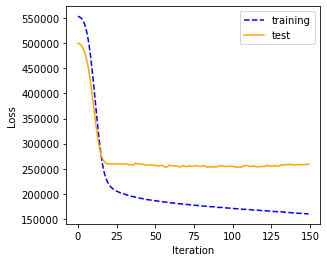

(train rmse, test rmse)=(398.75,508.25)


In [130]:
y = processed_CLIs_df[['Overall_Survival']]
SVD_full_X_train, SVD_full_X_test, y_train, y_test = train_test_split(SVD_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
SVD_full_X_train = sc.fit_transform(SVD_full_X_train)
SVD_full_X_test = sc.transform(SVD_full_X_test)

''' Plot loss-iteration for (14, 24) '''
SVD_full_NN_model = build_full_NN(50,14, 24)
SVD_full_history = SVD_full_NN_model.fit(SVD_full_X_train, y_train, validation_data=(SVD_full_X_test, y_test), batch_size = 10, epochs = 250, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(SVD_full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(SVD_full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, SVD_full_NN_model.predict(SVD_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, SVD_full_NN_model.predict(SVD_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


In [131]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    SVD_full_NN_model = build_full_NN(50,a, b)
    SVD_full_history = SVD_full_NN_model.fit(SVD_full_X_train, y_train, validation_data=(SVD_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, SVD_full_NN_model.predict(SVD_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, SVD_full_NN_model.predict(SVD_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))

(first_layer, second_layer, train rmse, test rmse)=(8,4,429.01,487.0)
(first_layer, second_layer, train rmse, test rmse)=(8,6,433.51,487.2)
(first_layer, second_layer, train rmse, test rmse)=(8,8,428.6,490.05)
(first_layer, second_layer, train rmse, test rmse)=(8,10,421.19,511.95)
(first_layer, second_layer, train rmse, test rmse)=(8,12,426.69,487.09)
(first_layer, second_layer, train rmse, test rmse)=(8,14,417.16,493.07)
(first_layer, second_layer, train rmse, test rmse)=(8,16,420.56,499.09)
(first_layer, second_layer, train rmse, test rmse)=(8,18,414.9,520.0)
(first_layer, second_layer, train rmse, test rmse)=(8,20,428.92,491.32)
(first_layer, second_layer, train rmse, test rmse)=(8,22,414.48,519.63)
(first_layer, second_layer, train rmse, test rmse)=(8,24,420.11,497.64)
(first_layer, second_layer, train rmse, test rmse)=(10,4,425.48,496.84)
(first_layer, second_layer, train rmse, test rmse)=(10,6,432.02,483.88)
(first_layer, second_layer, train rmse, test rmse)=(10,8,420.95,488.27)


In [132]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(20, 4, 416.16779954786955, 481.42392268727417)

In [ ]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")

not as good as svd on genomic only==>keep it
